# 0 Importing Libraries and Data Loading
In the first part of this chapter we are going to load the different libraries, load the data and have a quick look at the data itself and how it is distributed.

In [1]:
# Libraries importieren
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots
import os
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import eli5
from eli5.sklearn import PermutationImportance
import graphviz
import shap

Using TensorFlow backend.


In [2]:
vgsales = pd.read_csv("/kaggle/input/vgsales.csv")
vgsales.isna().sum()
vgsales = vgsales.dropna()

In [3]:
vgsales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16291 entries, 0 to 16597
Data columns (total 11 columns):
Rank            16291 non-null int64
Name            16291 non-null object
Platform        16291 non-null object
Year            16291 non-null float64
Genre           16291 non-null object
Publisher       16291 non-null object
NA_Sales        16291 non-null float64
EU_Sales        16291 non-null float64
JP_Sales        16291 non-null float64
Other_Sales     16291 non-null float64
Global_Sales    16291 non-null float64
dtypes: float64(6), int64(1), object(4)
memory usage: 1.5+ MB


In [4]:
vgsales.head()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


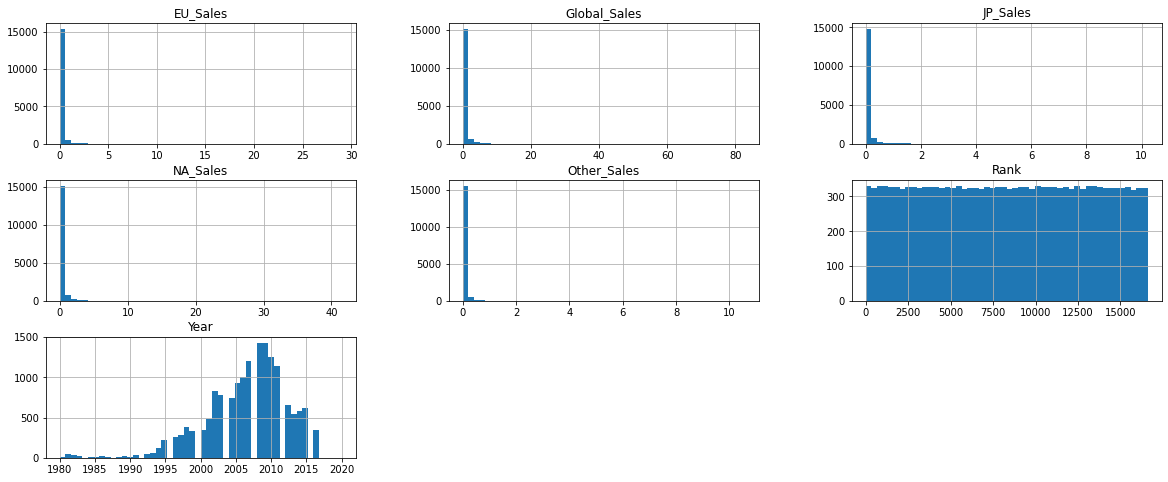

In [5]:
numeric_features = [i for i in vgsales.columns if vgsales[i].dtype in [np.int64, np.float64]]
vgsales[numeric_features].hist(bins=50, figsize=(20,8))
plt.show()

Looking at the distribution of the different numeric variables we see that the sales are heavely skewed and the majority of games how a low salesamount. Having a look at the rank feature we see that it is distributed evenly and the observations per year are more frequent in the two thousands. 

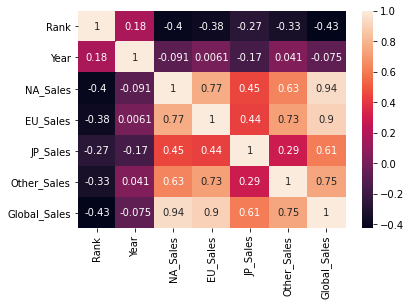

In [6]:
corrMatrix = vgsales[numeric_features].corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

Having a look at the coorelation Matrix we see that the only features with a strong correlation with each other are the sales features. 

# 1 Explainability
Unlike many other statistical methods, the interpretability is not based on mathematics. Tim Miller (2017) has defined interpretability to describe how well a person can understand the cause of a decision. This is especially important, because in machine learning, the human does not teach the computer how to respond, but the computer itself learns from the data. Interpretability can only be measured between different models and one model is more interpretable than the other if a human being can understand this more easily or can understand the reason for a decision more easily.

# 1.1 Importance of Explainability
The question is now, why it is important for a human to understand a Machine Learnin model, since it is also easy to trust the computer and its decision. As in many statistical topics there is a compromise. The two variables here are "what" and "why". In other words, we have to decide whether we want to know exactly what happens or whether we are more interested in the reason for the decision. Some scenarios do not need an explanation because an error in the prediction is insignificant. In other scenarios, such as cancer prediction, an incorrect prediction can have drastic consequences. The importance of interpretability comes from the fact that the prediction itself (what) is not sufficient and it must be predicted how it happened. To return to the example of breast cancer, this would mean that a model must not only predict that a patient has breast cancer but also what metrics it has used to detect it.

Another important point is that people recognize patterns that may not be patterns and that may just be random. This can be proven in some scientific tests, such as the pipe shaft test (it would be interesting to see what an ML model would detect). In other words, interpretability can help people recognize the patterns and avoid making false conclusions.

# 1.2 Taxonomy of interpretability
The methods for the interpretability of ML models can be classified according to various criteria.

(a) Intrinsic or post hoc: A distinction is made here between whether interpretability is measured by limiting complexity (intrinsic) or by analysing the model after the training phase (post hoc). Intrinsically interpretable models include, for example, short decision trees, since their structure is simple.

(b) Results of the interpretation method: There are different methods which can be divided into the following blocks (i) Feature Summary Statistics, (ii) Feature Summary Visualization, (iii) Model Internals and (iv) Data Points. (i) Many interpretability methods give an overview of the individual features. This can be in the form of one or more key figures. (ii) Many of these feature summaries can also be visualized in a graph. Furthermore, Feature Summaries need to be visualized urgently, otherwise they would not be interpretable, for example in the Partial Dependence Plot. (iii) The interpretation of intrinsic methods falls into this category. Examples would be learned tree structures, among others. (iv) This includes all methods which use data points for interpretability. The data points can already exist or be newly created. The Counterfactual Method uses this for example by creating a data point which is quite similar to an existing data point but which changes the prediction significantly.

(c) Model-specific or model-agnostic: Model-specific introduction tools are limited to specific models. The interpretation of the coefficients of a linear regression would be model-specific interpretation. Model diagnostic tools are post hoc methods that analyze the inputs and outputs. They do not have access to intrinsic information, such as coefficients or structures.

(d) Local or global: The question must be asked whether the interpretation method explains individual predictions or the whole model. It may also be possible that the scope lies between inside. Questions or food for thought that may help include (i) how was the model constructed, (ii) how does the model make predictions, (iii) how do certain parts of the model influence the predictions, (iv) why did the model make a particular prediction for a value, and (v) why did the model make particular predictions for a group of values.

# 1.3 Properties of explanations
The properties of explanations can be divided into two broad blocks (a) properties of explanation methods and (b) properties of individual interpretations.

(a) Properties of explanatory methods: This in turn can be divided into the following categories (i) expressiveness, (ii) permeability, (iii) transferability and (iv) algorithmic complexity. The expressiveness (i) describes the structure of the interpretation that the method can create. For example, this could be a simple If X Then Y structure, but is not limited to this. Permeability (ii) describes how much the method "looks" into the model itself to make an interpretation. The transferability (iii) describes which ML models can be interpreted with the corresponding method. The algorithmic complexity (iv) describes how much computational effort is needed for the interpretability, which is important as soon as computing power is not available indefinitely (i.e. always).

(b) Characteristics of individual interpretations This can be divided into the following nine categories (i) accuracy, (ii) fidelity, (iii) consistency, (iv) stability, (v) comprehensibility, (vi) certainty, (vii) importance, (viii) novelty and (ix) representation. Accuracy (i) describes how well the interpretability is transferable to new data. Fidelity (ii) is in close cooperation with accuracy and focuses on how well the interpretability approximates the prediction from a black box model (e.g. neural network). Consistency (iii), meanwhile, deals with how interpretability differs from two models trained with the same data. In contrast, stability (iv) measures interpretability within a model between different predictions. Comprehensibility (v) is simply how well people understand the interpretation. Certainty (vi) describes how certain an ML model is in prediction.

# 2 Interpretable models
The interpretable models are roughly divided into two different categories (a) regression and (b) classification. The following section briefly discusses a few of the most common models and presents their advantages and disadvantages. Since the selected dataset is not ideal for all models, the following sections will occasionally use different datasets in order to explain the interpretability of the models and to avoid that the models suffer from the quality of the dataset and the limited possibilities.

# 2.1 Linear regression
Despite the triviality of linear regression, it is briefly explained in the following section for the sake of completeness. Linear regression is the simplest method for making predictions. The form of linear regression is a simple straight line, where the formula looks like this: ![linear_regression_basic_function.PNG](attachment:linear_regression_basic_function.PNG)

A simple linear regression has one influence quantity (X1) and two weights. The first weight (Beta0) represents the point of intersection with the Y-axis. The second weight (Beta1) represents the slope of the straight line in a simple linear regression. Furthermore, the equation still contains an error term, which represents the irreducible error. In multiple linear regression, there are several influencing variables (X1...Xn) which want to describe the target variable (Y) as well as possible. 

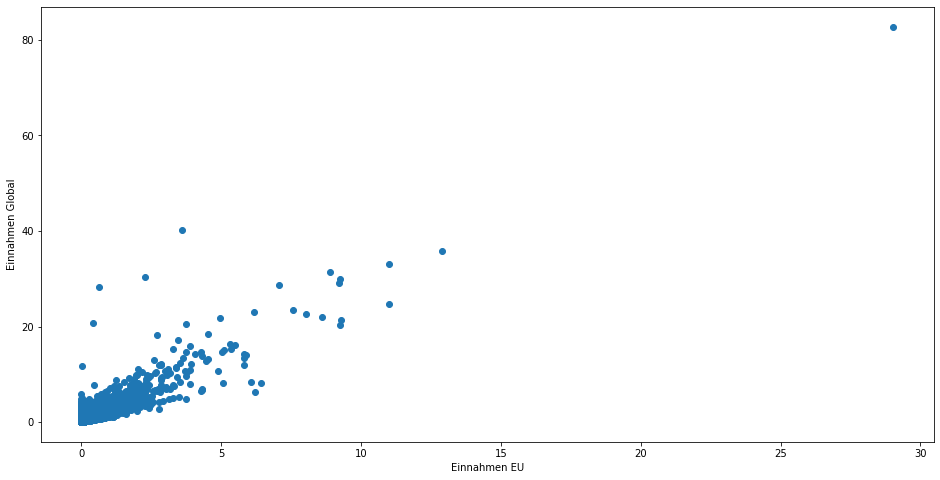

In [7]:
plt.figure(figsize=(16, 8))
plt.scatter(
    vgsales["EU_Sales"], 
    vgsales["Global_Sales"]
)
plt.xlabel("Einnahmen EU")
plt.ylabel("Einnahmen Global")
plt.show()

In [8]:
y = vgsales["Global_Sales"].values.reshape(-1,1)
X = vgsales["EU_Sales"].values.reshape(-1, 1)

regression = LinearRegression(normalize=True)
regression.fit(X, y)

print("The linear model is: Y = {:.5} + {:.5} * EU_Sales".format(regression.intercept_[0], regression.coef_[0][0]))

The linear model is: Y = 0.13026 + 2.7797 * EU_Sales


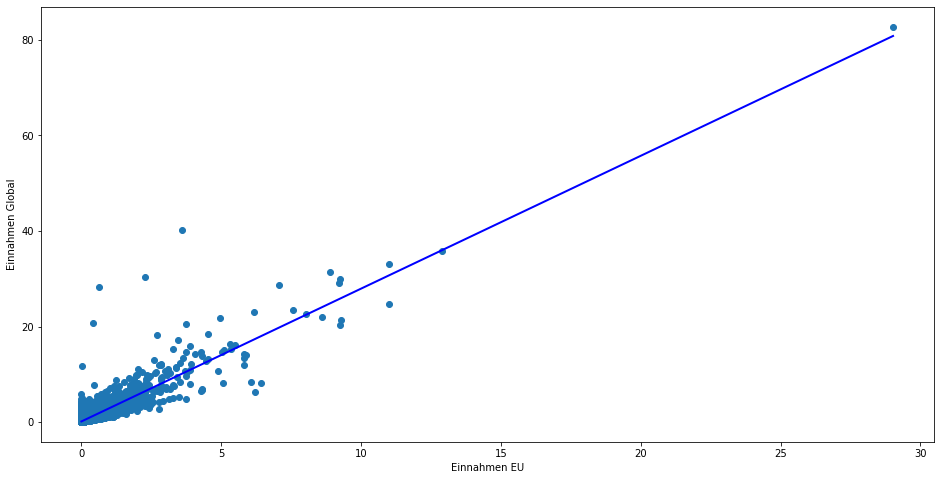

In [9]:
predictions = regression.predict(X)

plt.figure(figsize=(16, 8))
plt.scatter(
    vgsales["EU_Sales"], 
    vgsales["Global_Sales"]
)
plt.plot(
    vgsales["EU_Sales"],
    predictions,
    c="blue",
    linewidth=2

)
plt.xlabel("Einnahmen EU")
plt.ylabel("Einnahmen Global")
plt.show()

In the upper model we see that we could very well predict the "Global_Sales" on the basis of the "EU_Sales". We could also create a multiple linear regression with the different platforms or other regions to show the global sales again. Since the focus of this paper is on the theory of the different models, it is sufficient to present a simple model to the reader without going into further detail. The main advantages of linear regression are, among other things, that it is the simplest model for prediction and many people have had contact with it in one form or another. Furthermore, it is very transparent how the results are obtained, since there is an equation to the model, which is limitedly complicated by the linearity. One of the disadvantages of linear regression is that most events are not linearly related and therefore reality is difficult to predict. In addition, multiple linear regression requires attention to multicollinearity, which is a problem when several influencing variables correlate strongly. 

# 2.2 Logistic regression
In contrast to linear regression, logistic regression classifies its results. Logistical regression produces one of two outcomes. In our example, we could, for example, predict the probability that the game we want to predict will fall into the category "Sports". For the prediction the formula of the following form is used: 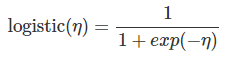
The predications are then always in the order of [0, 1]. The threshold value for differentiation is usually 0.5. If the value is below 0.5, we predicate that the game does not fall into the category "Sports". With a value of more than 0.5 we predicate that the game belongs to the category "Sports".

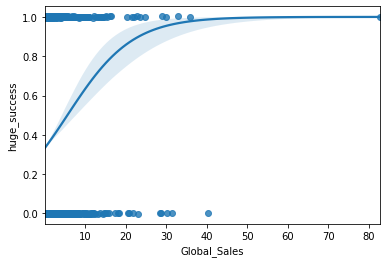

In [10]:
vgsales["huge_success"] = (vgsales["EU_Sales"] / vgsales["Global_Sales"]) > .30
ax = sns.regplot(x="Global_Sales", y="huge_success", data=vgsales,
                 logistic=True, n_boot=1000, y_jitter=.003)

In this graph we see the result of a logistic regression when we want to determine if a game has had a big success in Europe. The basis for the decision is if more than 30% of the global turnover has taken place in Europe, then it is a great success in Europe. It is clearly visible that the higher the global turnover, the greater the chance that the game is a great success in Europe.


Logistic regression is also quite easy to interpret and it is therefore easy for a person to understand into which category a prediction falls or which result is more likely. Like linear regression, however, it is quite limited in its power and other models are better at predicting. One problem that can occur with logistic regression is complete separation. This means that an influence quantity separates both classes perfectly from each other. This means that no logistic regression could be done, because both influence variables are already separated. An advantage of logistic regression is that it is not only a simple classification, but we also get a probability.

# 2.3 GLM and GAM
In a previous chapter we have already heard about Generlized Linear Models (GLMs). Now let's have a look at the topic again in the context of explicability. In this chapter we will also look at the Generalized Additive Models (GAMs). For many problems a prediction by linear regression is usually too inaccurate. A major problem of linear regression is that the prediction follows a noisy distribution. It neglects the prediction of categories, the prediction of a number or possibly the prediction of data with a very large skew, such as income. With a GLM, such predictions can also be made. 

GAMs are a good solution if we want to make a prediction of non-linear situations. Unfortunately, most things are not so simple that increasing X will result in a beta 1-fold increase of Y. It may be the case that this may be the case for a limited interval, but at some point we will see reduced increases. For example, if we look at the sale of trousers. If we increase the price of a pair of pants, then we will probably see little difference for the first few Euros. At a certain point, however, the number of pants we buy will decrease very quickly and if we continue to increase the price, we will probably not sell many more. To find out the exact shape of this curve, tests would have to be made, but we can say with certainty that the interaction is not linear. 

# 2.4 Decision trees
Decision trees subdivide the data based on different values in the features. These subdivisions create subsets from the original data set. Decision trees can be used for regression or classification. Interpreting a decision tree is quite simple, since we start at the root node and go to the next branch, and then use our cutoff value for the feature to decide how to proceed. 

In [11]:
y = (vgsales["Genre"] == "Sports")
feature_names = [i for i in vgsales.columns if vgsales[i].dtype in [np.int64, np.float64]]
X = vgsales[feature_names]
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
tree_model = DecisionTreeClassifier(random_state=0, max_depth=5, min_samples_split=5).fit(train_X, train_y)

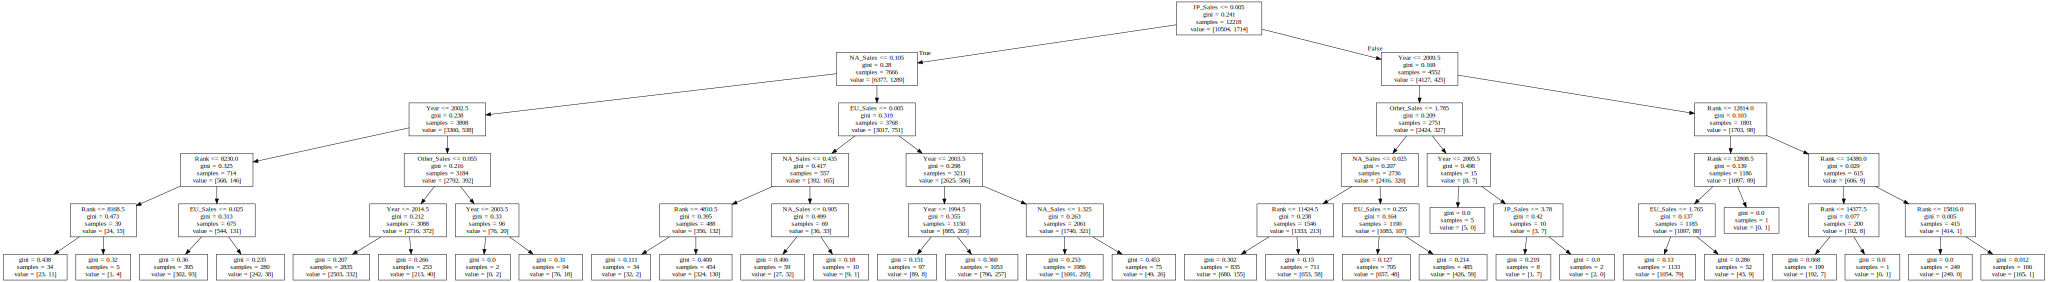

In [12]:
tree_graph = tree.export_graphviz(tree_model, out_file=None, feature_names=feature_names)
graphviz.Source(tree_graph)

The advantages of decision trees are that we can, for example, identify interactions between different features in our data. It is also very easy to understand the model, since we only have to go from "branch" to "branch" to understand why a decision was made. Nevertheless, decision trees also have problems. Decision trees cannot represent linear relationships. Furthermore, the smallest changes in the input values can lead to drastic changes in the decision tree. Furthermore, it may also be the case that we want to make a prediction close to the cutoff value. A small change may cause us to fall into one category or another, even though the difference is only marginal. In most cases this is not understandable. 

# 3 Model Agnostic Methods
Model-agnostic methods are understood as the separation of the ML model from its interpretation. The biggest advantage of this is the flexibility gained. If we look at this in practice, we do not know at the beginning which is the best ML model. If a model-specific approach is chosen to interpret the results, it is not always easy to compare the models. If model-agnostic methods are used for the interpretation, this makes it easier to compare different ML models. Three important aspects for model-agnostic interpretations are (Ribeiro, Singh, and Guestrin 2016)
(a) Model flexibility: How many different ML approaches can be explained?
(b) Interpretation flexibility: How free are we in deciding how to interpret a model? 
(c) Representation flexibility: How different are the features of the ML model from the features of the interpretation?

# 3.1 Partial Dependence Plot
With a Partial Dependence Plot we can find out what the relationships between different variables look like, in other words we can determine if a relationship is linear, monotone or more complex. The advantage of the PDP is that the interpretation of the models is quite intuitive and therefore quite easy to understand for many people. In contrast, the disadvantages are greater. Among other things, only a limited number of features can be represented, because the PDP is always 2 dimensional. Another disadvantage is that background information is lost. This could include not taking into account correlations with other features that were not used for the PDP. 

Concerning the Partial Dependence Plots, we again use the graph of Molnar (2020). In the first example, the number of different bicycle rentals is calculated using different weather metrics. 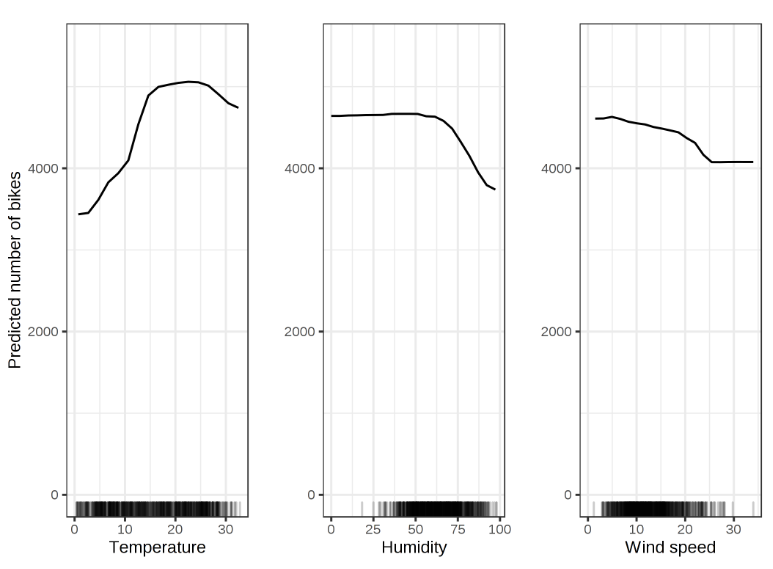

If we look at the model from a rental perspective, we quickly understand that at low temperatures only a few people would rent a bike. Moreover, once the temperature reaches a threshold and becomes too hot, the number of rentals will decrease. In the same approach, humidity and wind speed can be explained.

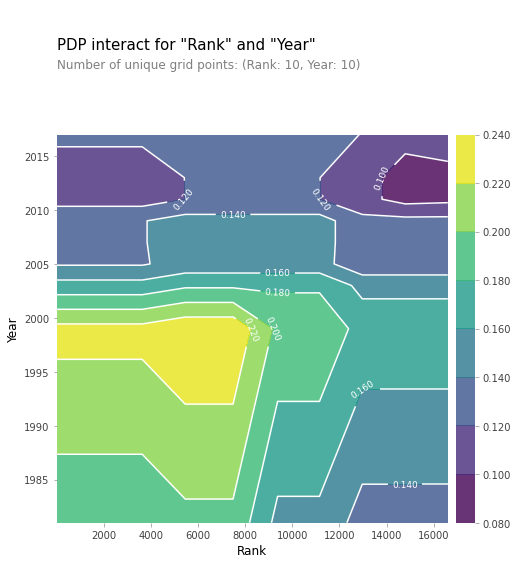

In [13]:
features_to_plot = ['Rank', 'Year']
inter1  =  pdp.pdp_interact(model=tree_model, dataset=val_X, model_features=feature_names, features=features_to_plot)

pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot, plot_type='contour')
plt.show()

In the upper PDP we see the interaction between the ranking of the game and the year of release in predicting sales in the different territories and global sales. We see that between 1993 and 2000 were the best years for video games.

# 3.2 Shapley Values
The basic idea of Shapley Values is that a prediction can be explained by considering the different feature values as "players" and the prediction is a payout. The Shapley Values describe how we can distribute the payout fairly between the different features. 
Let's look at the idea again with bike rental. First, we create so-called coalitions, which is nothing else than a power set of the features. Then we compare different subsets of the power set with each other and see what difference we have in the results, e.g. if we have one more feature or not. We do this for all features we want to use for the predication. Since we have the differences of many subsets, we take the average of them and get the average influence of a feature on the prediction. For bicycle rental this looks like this (Molnar, 2020)
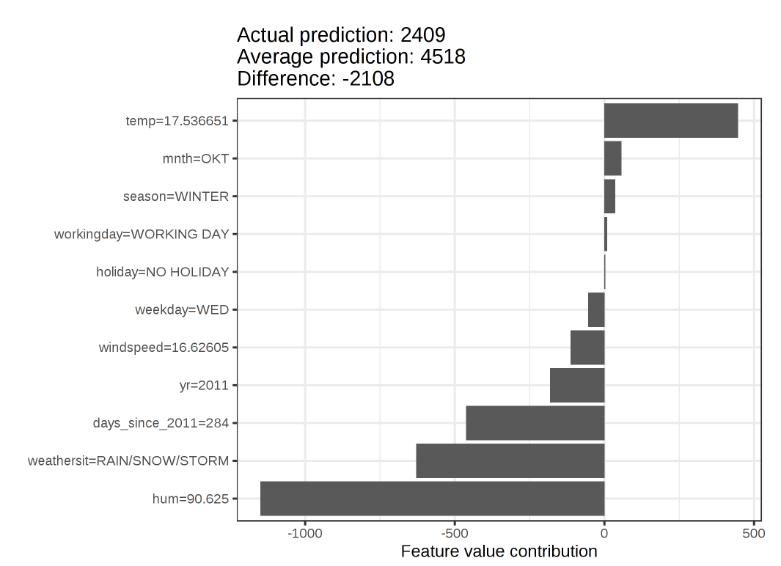

If we take a look at the Shapley Values from the bike rental this is for example the case with the feature "days_since_2011". We already know from other features that we are in the month of October (which on average has a positive effect on the prediction), but the exact day of the year has a negative average effect on the number of bikes rented. 

In [14]:
y = (vgsales["Genre"] == "Sports")
feature_names = [i for i in vgsales.columns if vgsales[i].dtype in [np.int64, np.float64]]
X = vgsales[feature_names]
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
shap_model = RandomForestClassifier(random_state=0).fit(train_X, train_y)

In [15]:
row_to_show = 5
data_for_prediction = val_X.iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)


shap_model.predict_proba(data_for_prediction_array)

array([[1., 0.]])

In [16]:
explainer = shap.TreeExplainer(shap_model)
shap_values = explainer.shap_values(data_for_prediction)

In [17]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction)

If we apply the Shapley Values to our data, we see that the JP_Sales and EU_Sales features on average have a negative impact on the result. All other features have a positive impact on the model, with a greater influence (in terms of absolut amount).

Shapley values have some limitations. By using subsets of a power set we get a huge amount of subsets to compare with each other. In other words, it takes a lot of computing power to calculate Shapley Values. In addition, Shapley Values always uses all features for prediction, which in some cases may not be intuitive.

# 3.3 Permutation Feature Importance
One of the most important questions we will ask ourselves during modelling is: Which feature has the greatest influence on our predictions? We measure the importance of a feature by measuring the increase in prediction error after the permutation. A feature is important if we can measure an increase in error by permuting its values. In other words, our model depends on the feature for prediction. We can do this for all features of a model and finally compare the results. Permutaion Feature Importance has several advantages, and one of the more important advantages is that all interactions between features are considered and the results are comparable across different problems. The disadvantages are that the actual results must be known, otherwise no Feature Importance can be calculated. Furthermore, correlating features reduce the importance of each other. 

In [18]:
y = (vgsales["Genre"] == "Sports")
feature_names = [i for i in vgsales.columns if vgsales[i].dtype in [np.int64, np.float64]]
X = vgsales[feature_names]
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
my_model = RandomForestClassifier(n_estimators=100,
                                  random_state=0).fit(train_X, train_y)

In [19]:
perm = PermutationImportance(my_model, random_state=1).fit(val_X, val_y)
eli5.show_weights(perm, feature_names = val_X.columns.tolist())

Weight,Feature
0.0105 ± 0.0045,Year
0.0029 ± 0.0033,EU_Sales
-0.0041 ± 0.0060,NA_Sales
-0.0073 ± 0.0026,Other_Sales
-0.0098 ± 0.0040,JP_Sales
-0.0199 ± 0.0010,Rank
-0.0220 ± 0.0025,Global_Sales


For our dataset we have now calculated the Importance feature if we want to predict the "Sports" genre. We see that the year has the greatest influence on the model. We also see at a glance one of the disadvantages of Feature Importance, since the correlating feature Global_Sales has the worst score. This is because most other features correlate with it. 

In [20]:
y = (vgsales["Genre"] == "Role-Playing")
feature_names = [i for i in vgsales.columns if vgsales[i].dtype in [np.int64, np.float64]]
X = vgsales[feature_names]
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
my_model = RandomForestClassifier(n_estimators=100,
                                  random_state=0).fit(train_X, train_y)

In [21]:
perm = PermutationImportance(my_model, random_state=1).fit(val_X, val_y)
eli5.show_weights(perm, feature_names = val_X.columns.tolist())

Weight,Feature
-0.0000 ± 0.0023,JP_Sales
-0.0047 ± 0.0035,Year
-0.0093 ± 0.0021,Other_Sales
-0.0102 ± 0.0029,EU_Sales
-0.0125 ± 0.0027,NA_Sales
-0.0142 ± 0.0023,Rank
-0.0174 ± 0.0026,Global_Sales


Having a look at another genre we want to predict we can see that the feature importance has shifted. For the genre "Role-Playing" the sales in Japan are the most important feature as opposed to the year in the previous feature importance permutation.

# Conclusion
The conclusion of this chapter is that we have many different possibilities to show the interpretability of ML models. Most of the results can be visualized and therefore it is easier for borrowers to understand the models. Nevertheless, it is also essential for experts to understand the model and how a result was achieved.  It is important to choose the right interpretability models to describe the ML model. 

# Quellen für dieses Kapitel
* https://christophm.github.io/interpretable-ml-book/
* https://seaborn.pydata.org/generated/seaborn.regplot.html
* https://www.kaggle.com/learn/machine-learning-explainability
* Ribeiro, Marco Tulio, Sameer Singh, and Carlos Guestrin. “Model-agnostic interpretability of machine learning.” ICML Workshop on Human Interpretability in Machine Learning. (2016)
* Miller, Tim. “Explanation in artificial intelligence: Insights from the social sciences.” arXiv Preprint arXiv:1706.07269.(2017)